# Pozo Harmónico

In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

# Definición del Sistema

In [3]:
system = mm.System()
mass = (12.010*15.999)/(12.010+15.999) * unit.amu # masa reducidad de la molecular diatómica: C-O
print('Masa:',mass)
system.addParticle(mass)

Masa: 6.86022314256132 Da


0

# Paisaje Energía Potencial

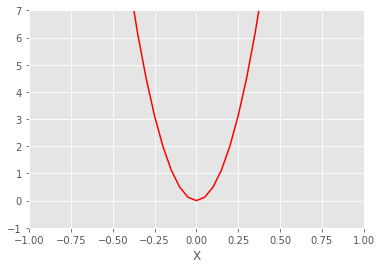

In [4]:
# '0.5*K*x**2'

def harmonic_well(x,K):
    return 0.5*K*x**2

K=100.0

x_serie = np.arange(-5., 5., 0.05)
plt.rcParams['figure.figsize'] = 6,4
plt.plot(x_serie, harmonic_well(x_serie,K), 'r-')
plt.ylim(-1,7)
plt.xlim(-1,1)
plt.xlabel("X")
plt.show()

In [5]:
x = sy.symbols('x')
f=0.5*K*x**2

g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

roots_x=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_x.append(root)
        T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
        print('Minimo en coordenada',root,'con k effectiva',effective_k,' y un periodo T de oscilación',T)

Calculamos las raices:

Función: 50.0*x**2
Primera derivada: 100.0*x
Segunda derivada: 100.000000000000
Minimo en coordenada 0 con k effectiva 100.000000000000  y un periodo T de oscilación 0.08045502081776873 ps


In [6]:
### Añadiendo el potencial al sistema

In [7]:
force = mm.CustomExternalForce('(K/2.0) * (x^2 + y^2 + z^2)')
force.addGlobalParameter('K', K * unit.kilocalories_per_mole/unit.angstrom**2)
force.addParticle(0, [])
system.addForce(force)

0

# Estado termodinámico

In [8]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Parámetros de la simulación

In [9]:
step_size       = 0.004*unit.picoseconds
num_steps       = 4000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

# Integrador

In [10]:
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Plataforma de simulación

In [11]:
platform_name = 'CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

# Reporteros y arrays de salida

In [12]:
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales

In [13]:
initial_positions  = [[0.0, 0.0, 0.0]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [14]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [15]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 40000/40000 [11:05<00:00, 60.09it/s]


# Análisis de resultados

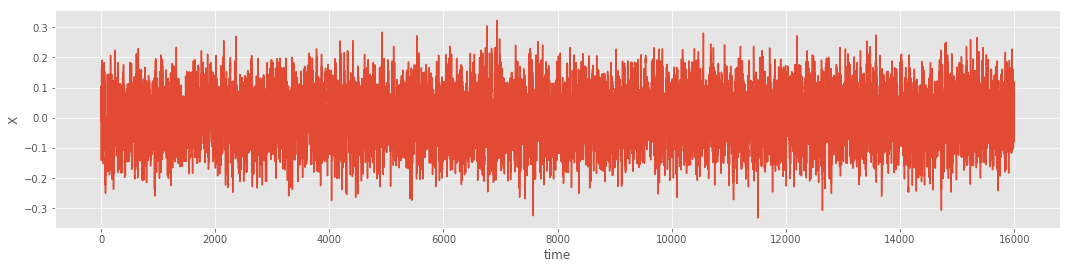

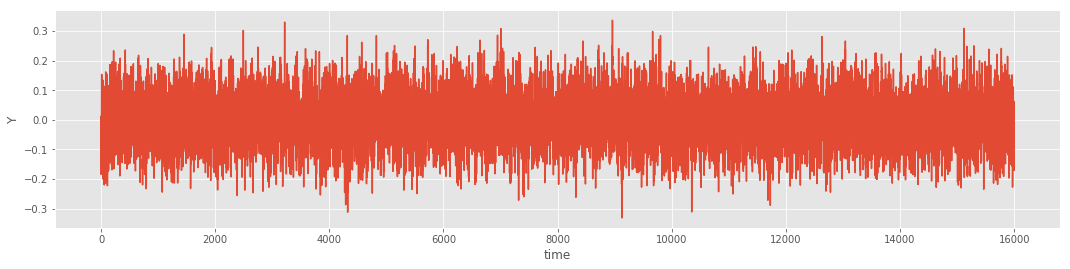

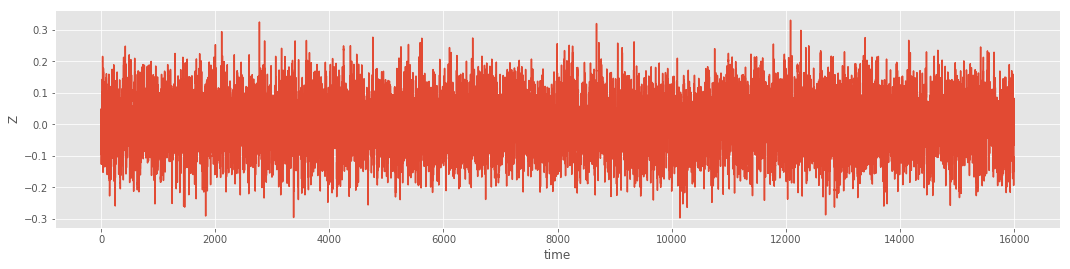

In [16]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

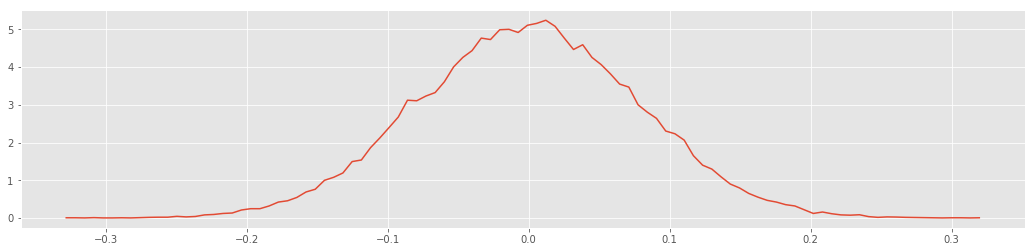

In [17]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)

/home/diego/Myusr/opt/miniconda3/envs/academia/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


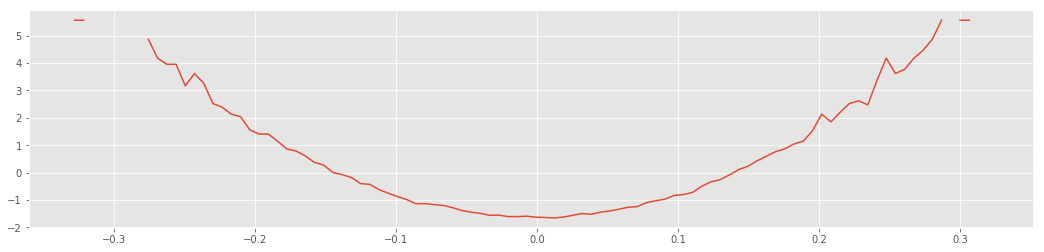

In [18]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))

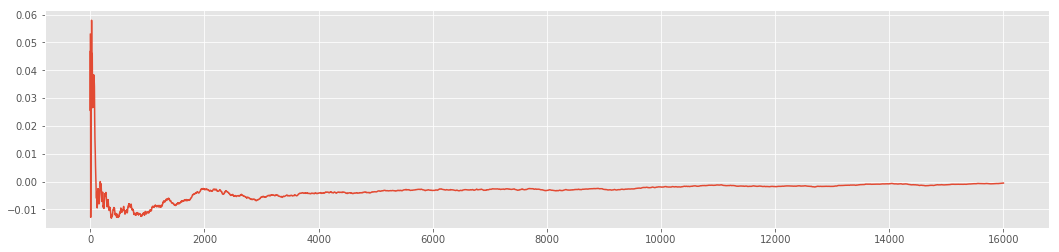

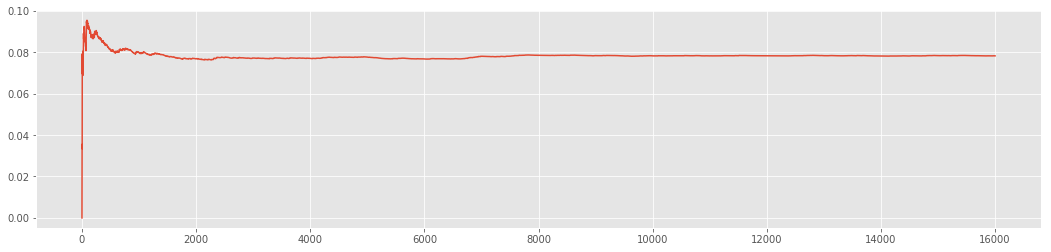

In [19]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

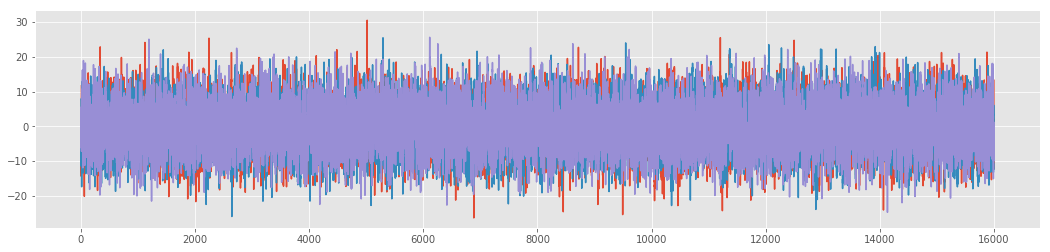

In [20]:
plt.plot(times,velocities)

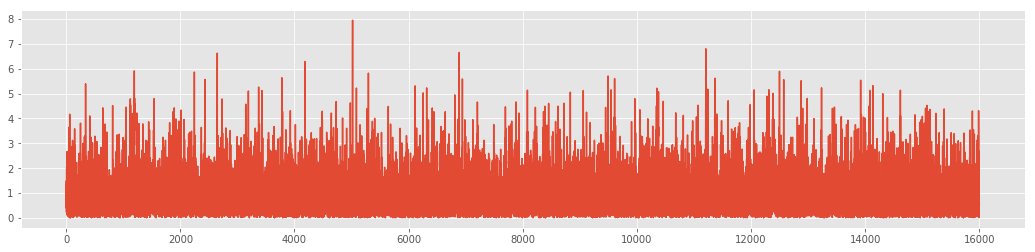

In [21]:
plt.plot(times,kinetic_energies)

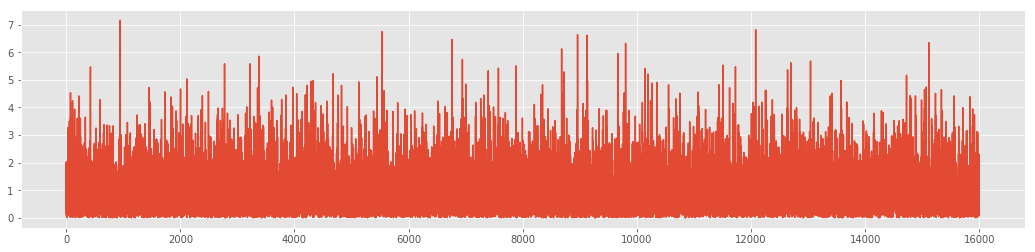

In [22]:
plt.plot(times,potential_energies)

T = sqrt(m/K) timestep smaller than ~ T/10 standard deviation in each dimension sigma= (kT / K)^(1/2) Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT

# TODO
- comprobar con que damping es sobre-amortiguado
- comprobar el delta de maximo permitido
- comprobar la energía por grado de libertad
- comprobar la distribución de velocidades
- comprobar la energía cinética promedio
- comprobar la dependencia con la masa
- comprobar que el periodo está bien calculado